# Part 1: Dataset Setup & Preprocessing

In this section, we will:
1. Download the Flickr8k dataset using the provided Kaggle snippet.
2. Explore the dataset structure (images and captions file).
3. Preprocess the captions by cleaning the text, tokenizing, building a vocabulary (with a minimum frequency threshold), and adding special tokens (`<start>` and `<end>`).
4. Split the dataset into training, validation, and test sets.


In [ ]:
# %% [code]
# 1. Dataset Setup & Preprocessing

# a. Downloading the Dataset
# Note: The dataset gets downloaded directly as a file. We assume the directory structure is:
# flickr8k/versions/1/Images/  (contains images, e.g., im1.jpg, etc.)
# flickr8k/versions/1/captions.txt  (CSV file with header "image,caption")

import kagglehub
import os
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
from sklearn.model_selection import train_test_split

# Download the dataset from Kaggle
data_dir = kagglehub.dataset_download("adityajn105/flickr8k")
print("Path to dataset files:", data_dir)

# Define the main data directory (adjust according to the downloaded structure)
images_dir = os.path.join(data_dir, "Images")
captions_file = os.path.join(data_dir, "captions.txt")

# b. Understanding the Dataset Structure
# List the files in the main data directory
print("\nContents of data directory:")
print(os.listdir(data_dir))
print("\nContents of Images directory:")
print(os.listdir(images_dir)[:5])  # print first 5 image file names

# c. Text Preprocessing
# Load the captions file. The file is CSV-like with a header "image,caption".
captions_df = pd.read_csv(captions_file)
print("\nFirst few rows of captions file:")
print(captions_df.head())

# Define a function to clean captions
def clean_caption(caption):
    # Convert to lowercase
    caption = caption.lower()
    # Remove punctuation using regex
    caption = re.sub(f"[{re.escape(string.punctuation)}]", "", caption)
    # Remove any extra whitespace
    caption = re.sub("\s+", " ", caption).strip()
    return caption

# Clean all captions in the dataframe
captions_df['clean_caption'] = captions_df['caption'].apply(clean_caption)
print("\nCaptions after cleaning:")
print(captions_df[['caption', 'clean_caption']].head())

# Add special tokens <start> and <end> to each caption
captions_df['final_caption'] = captions_df['clean_caption'].apply(lambda cap: f"<start> {cap} <end>")

# Tokenize captions: split each caption into words
captions_df['tokens'] = captions_df['final_caption'].apply(lambda cap: cap.split())
print("\nTokenized captions:")
print(captions_df[['final_caption', 'tokens']].head())

# Build Vocabulary: count word frequencies and create a mapping from word to index.
# Here, we can also set a minimum word frequency if needed (e.g., min_count = 1 means no filtering)
min_count = 1
word_counter = Counter()
for tokens in captions_df['tokens']:
    word_counter.update(tokens)

# Filter words below the min_count threshold
vocab = [word for word, count in word_counter.items() if count >= min_count]
print("\nTotal unique words in vocabulary:", len(vocab))

# Create word2idx and idx2word mappings
word2idx = {word: idx+1 for idx, word in enumerate(vocab)}  # starting indices from 1; reserve 0 for padding.
idx2word = {idx: word for word, idx in word2idx.items()}

# Optionally, print some vocabulary items
print("\nSample vocabulary items:")
sample_vocab = list(word2idx.items())[:10]
for word, idx in sample_vocab:
    print(f"{word}: {idx}")

# d. Data Splitting: Split by unique images.
# Since each image can have multiple captions, we split based on unique image names.

# Get list of unique image names from the captions file.
unique_images = captions_df['image'].unique()
print("\nTotal unique images:", len(unique_images))

# Split into 80% train, 10% validation, and 10% test.
train_images, temp_images = train_test_split(unique_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

print("\nTrain images count:", len(train_images))
print("Validation images count:", len(val_images))
print("Test images count:", len(test_images))

# Create a function to filter captions based on image split
def filter_captions(df, image_list):
    return df[df['image'].isin(image_list)]

# Filter the dataframe for each split
train_df = filter_captions(captions_df, train_images)
val_df = filter_captions(captions_df, val_images)
test_df = filter_captions(captions_df, test_images)

print("\nExample from training captions:")
print(train_df.head())

# Save or return the processed data as needed for later parts of the project.
# For example, you might want to save the vocabulary or split dataframes using pickle or another format.


Path to dataset files: /kaggle/input/flickr8k

Contents of data directory:
['captions.txt', 'Images']

Contents of Images directory:
['3226254560_2f8ac147ea.jpg', '214543992_ce6c0d9f9b.jpg', '2366643786_9c9a830db8.jpg', '3368819708_0bfa0808f8.jpg', '2190227737_6e0bde2623.jpg']

First few rows of captions file:
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  

Captions after cleaning:
                                             caption  \
0  A child in a pink dress is climbing up a set o...   
1              A girl going

In [ ]:
# %% [code]
# 2. Image Feature Extraction with a Pretrained CNN

import os
import numpy as np
from tqdm import tqdm  # for progress bar

# Import Keras and TensorFlow libraries
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

# a. Choosing a Pretrained Model:
# We will use VGG16 with weights pretrained on ImageNet. We remove the top layers to use it as a feature extractor.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)
model.summary()  # Display model architecture once

# b. Preprocessing Images:
def preprocess_image(image_path):
    """
    Load an image, resize it to 224x224, convert it to array and preprocess it for VGG16.
    """
    img = load_img(image_path, target_size=(224, 224))  # resize image
    img_array = img_to_array(img)                       # convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)         # add batch dimension
    img_array = preprocess_input(img_array)             # preprocess using VGG16's preprocess_input
    return img_array

# c. Feature Extraction:
# Create a dictionary to store the feature vectors.
features_dict = {}

# List all image files from the images directory (assuming all files in the directory are images)
image_files = os.listdir(images_dir)
print(f"Total images found: {len(image_files)}")

# Loop over all images and extract features, with verbose=0 to suppress internal output.
for img_file in tqdm(image_files, desc="Extracting features"):
    img_path = os.path.join(images_dir, img_file)
    img_array = preprocess_image(img_path)
    # Extract features from the image; setting verbose=0 to avoid printing per-image output.
    features = model.predict(img_array, verbose=0)
    # Remove the batch dimension (features shape: (1, H, W, C))
    features = np.squeeze(features)
    # Save the features using the image file name as key
    features_dict[img_file] = features


In [ ]:
# Optionally, save the features dictionary for later use (e.g., using pickle or numpy)
!pip install google-colab-selenium
!pip install --ignore-installed blinker==1.7.0
!pip install selenium-wire

import time
import re
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import google_colab_selenium

# Initialize the WebDriver
driver = google_colab_selenium.Chrome()

# Open the target webpage
driver.get('https://www.playbook.com/s/imagenet10/kkob6wPaYd6TF2XouVezDwQJ?assetToken=FuxJVgrkwVKe6u1vhUjWxBhf')

try:
    # Wait for the download button to be clickable
    download_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.CLASS_NAME, 'AssetDownload_secondaryButton__rXjUO'))
    )

    # Click the download button
    download_button.click()
    print("Download button clicked.")

    # Wait for page to update
    time.sleep(3)

    # Extract storage URLs from page source
    page_source = driver.page_source
    storage_urls = re.findall(r'https://storage\.googleapis\.com[^"\'&\s]+', page_source)

    if storage_urls:
        # Clean the URL (remove escape sequences)
        download_url = storage_urls[0].replace('\\u0026', '&').replace('\\u003d', '=').replace('\\', '')
        print(f"Download URL found: {download_url}")

        if download_url:
            # Download the file using wget (the download_url variable is substituted)
            !wget --progress=bar:force -O /content/image_features.pkl "{download_url}"
        else:
            print("Download URL is not captured. Please run the previous cell to extract the URL first.")

    else:
        print("No download URL found in page source.")

except Exception as e:
    print(f"Error: {e}")
finally:
    # Close the WebDriver
    driver.quit()

import pickle
with open("image_features.pkl", "rb") as f:
    features_dict = pickle.load(f)

print(f"Extracted features for {len(features_dict)}")


  Using cached blinker-1.7.0-py3-none-any.whl.metadata (1.9 kB)
Using cached blinker-1.7.0-py3-none-any.whl (13 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 3.1.0 requires blinker>=1.9, but you have blinker 1.7.0 which is incompatible.


<IPython.core.display.Javascript object>

Download button clicked.
Download URL found: https://storage.googleapis.com/brandify-usercontent-dev/7865bc9e-34f3-4e6e-a19b-f879a3606d97?Expires=1743897599&GoogleAccessId=GOOG1EQYYUCN45RGYHGLHRS57FY5LN3ZFJOZEUIRTNHTBDZURLXQ4KVCAN4BI&Signature=0BBRZYIiyL8kIWCucP%2BUceOB3eE%3D%0A
--2025-04-04 13:09:26--  https://storage.googleapis.com/brandify-usercontent-dev/7865bc9e-34f3-4e6e-a19b-f879a3606d97?Expires=1743897599&GoogleAccessId=GOOG1EQYYUCN45RGYHGLHRS57FY5LN3ZFJOZEUIRTNHTBDZURLXQ4KVCAN4BI&Signature=0BBRZYIiyL8kIWCucP%2BUceOB3eE%3D%0A
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 812553238 (775M) [application/octet-stream]
Saving to: ‘/content/image_features.pkl’

/content/image_feat 100%[===================>] 774.91M  26.1MB/s    in 9.7s    

2025-04-04 13:09:36 (79.9 M

In [ ]:
# %% [code]
from tensorflow.keras.layers import Input, Flatten, Dense, RepeatVector, Embedding, LSTM, Concatenate, TimeDistributed
from tensorflow.keras.models import Model

# Define hyperparameters
embedding_dim = 256
lstm_units = 256

# Compute maximum caption length from the tokens in captions_df (created in Part 1)
max_length = captions_df['tokens'].apply(len).max()
print("Maximum caption length:", max_length)

# Define vocabulary size (we reserved index 0 for padding)
vocab_size = len(word2idx) + 1
print("Vocabulary size:", vocab_size)

# -------------------------------
# a. Encoder: Image Feature Processing
# -------------------------------

# Input for image features from Part 2 (features extracted from VGG16 have shape (7, 7, 512))
image_input = Input(shape=(7, 7, 512), name="image_input")
# Flatten the feature map to convert it to a vector (e.g., 7*7*512 = 25088 dimensions)
img_flat = Flatten()(image_input)
# Reduce dimensionality with a dense layer to match the embedding dimension
img_dense = Dense(embedding_dim, activation='relu')(img_flat)
# Repeat the processed image vector to match the caption sequence length
img_repeated = RepeatVector(max_length)(img_dense)

# -------------------------------
# b. Decoder: LSTM-based Language Model
# -------------------------------

# Input for caption sequences (each caption is represented as a sequence of word indices)
caption_input = Input(shape=(max_length,), name="caption_input")
# Embedding layer: map each word index to a dense vector.
# Setting mask_zero=False to avoid conflicts with the image features.
cap_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=False)(caption_input)

# Merge image features and caption embeddings:
# Concatenate the repeated image vector with the word embeddings at every time step.
merged = Concatenate(axis=-1)([img_repeated, cap_embedding])

# Process the merged input with an LSTM. Using dropout for regularization.
lstm_out = LSTM(lstm_units, return_sequences=True, dropout=0.5)(merged)

# Output layer: Use TimeDistributed to apply a Dense layer at each time step,
# predicting the probability distribution over the vocabulary.
outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(lstm_out)

# Define the complete model with two inputs: one for image features and one for caption sequences.
model = Model(inputs=[image_input, caption_input], outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

# Display the model architecture
model.summary()


Maximum caption length: 38
Vocabulary size: 8831


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 7, 7, 512)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      6,422,784 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ caption_input             │ (None, 38)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 38, 256)        │              0 │ dense[0][0]            │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 38, 256)        │      2,260,736 │ caption_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 38, 512)        │              0 │ repeat_vector[0][0],   │
│                           │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 38, 256)        │        787,456 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 38, 8831)       │      2,269,567 │ lstm[0][0]             │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,740,543 (44.79 MB)

 Trainable params: 11,740,543 (44.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# %% [code]
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# a. Data Generator: Custom Data Generator that yields batches for training
def data_generator_batch(df, features_dict, word2idx, max_length, batch_size):
    """
    Generator that yields batches for training.

    For each caption in the dataframe, this generator:
      - Converts the caption into a sequence of word indices.
      - Creates an input sequence (all tokens except the last) and a target sequence (all tokens except the first)
      - Pads both sequences to max_length.
      - Retrieves the corresponding image features.

    Yields:
      ((image_features, caption_input), target_output)
    """
    while True:
        img_features_batch = []
        cap_input_batch = []
        target_batch = []
        # Shuffle the dataframe rows each epoch
        for _, row in df.sample(frac=1).iterrows():
            image_file = row['image']
            caption = row['final_caption']
            # Convert caption into a list of word indices (skip words not in the vocabulary)
            seq = [word2idx[word] for word in caption.split() if word in word2idx]
            # Skip sequences that are too short for teacher forcing
            if len(seq) < 2:
                continue
            # For teacher forcing: input sequence is all words except the last, target is all words except the first
            input_seq = seq[:-1]
            target_seq = seq[1:]
            # Pad sequences to max_length
            input_seq = pad_sequences([input_seq], maxlen=max_length, padding='post')[0]
            target_seq = pad_sequences([target_seq], maxlen=max_length, padding='post')[0]
            # Get image features from precomputed features (skip if not found)
            if image_file not in features_dict:
                continue
            img_features = features_dict[image_file]
            # Append to batch lists
            img_features_batch.append(img_features)
            cap_input_batch.append(input_seq)
            target_batch.append(target_seq)

            # Yield a batch when the batch_size is reached
            if len(img_features_batch) == batch_size:
                # Convert lists to numpy arrays with appropriate dtypes
                img_features_batch_np = np.array(img_features_batch).astype('float32')
                cap_input_batch_np = np.array(cap_input_batch).astype('int32')
                target_batch_np = np.array(target_batch).astype('int32')
                # Expand target dims to match model output shape (batch_size, max_length, 1)
                target_batch_np = np.expand_dims(target_batch_np, axis=-1)
                yield ((img_features_batch_np, cap_input_batch_np), target_batch_np)
                img_features_batch = []
                cap_input_batch = []
                target_batch = []

# Set batch size
batch_size = 32


# Define output signature for our dataset generator.
# Expected structure: ((tf.float32, tf.int32), tf.int32)
output_signature = (
    (
        tf.TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32),
        tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)
    ),
    tf.TensorSpec(shape=(None, max_length, 1), dtype=tf.int32)
)

# Wrap the Python generators into tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator_batch(train_df, features_dict, word2idx, max_length, batch_size),
    output_signature=output_signature
)
val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator_batch(val_df, features_dict, word2idx, max_length, batch_size),
    output_signature=output_signature
)

# Prefetch for performance
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Calculate steps per epoch
steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size

# b. Training the Model: Define callbacks and start training
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Start model training
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[checkpoint, earlystop]
)


Epoch 1/20
1010/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.7464
Epoch 1: val_loss improved from inf to 1.64355, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 49s 40ms/step - loss: 2.7453 - val_loss: 1.6435
Epoch 2/20
1010/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.5916
Epoch 2: val_loss improved from 1.64355 to 1.42915, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 43s 42ms/step - loss: 1.5915 - val_loss: 1.4291
Epoch 3/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.4007
Epoch 3: val_loss improved from 1.42915 to 1.33430, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 80s 79ms/step - loss: 1.4007 - val_loss: 1.3343
Epoch 4/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.3087
Epoch 4: val_loss improved from 1.33430 to 1.29373, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - loss: 1.3087 - val_loss: 1.2937
Epoch 5/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.2691
Epoch 5: val_loss improved from 1.29373 to 1.28212, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 1.2691 - val_loss: 1.2821
Epoch 6/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.2496
Epoch 6: val_loss improved from 1.28212 to 1.26474, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - loss: 1.2496 - val_loss: 1.2647
Epoch 7/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.2240
Epoch 7: val_loss improved from 1.26474 to 1.24708, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 1.2240 - val_loss: 1.2471
Epoch 8/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.2013
Epoch 8: val_loss improved from 1.24708 to 1.24100, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 1.2013 - val_loss: 1.2410
Epoch 9/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.1950
Epoch 9: val_loss did not improve from 1.24100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - loss: 1.1950 - val_loss: 1.2427
Epoch 10/20
1010/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.1828
Epoch 10: val_loss improved from 1.24100 to 1.23337, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - loss: 1.1828 - val_loss: 1.2334
Epoch 11/20
1010/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.1746
Epoch 11: val_loss improved from 1.23337 to 1.22647, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - loss: 1.1746 - val_loss: 1.2265
Epoch 12/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.1680
Epoch 12: val_loss improved from 1.22647 to 1.22481, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - loss: 1.1680 - val_loss: 1.2248
Epoch 13/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.1637
Epoch 13: val_loss improved from 1.22481 to 1.22258, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 1.1637 - val_loss: 1.2226
Epoch 14/20
1010/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.1529
Epoch 14: val_loss improved from 1.22258 to 1.22080, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 1.1529 - val_loss: 1.2208
Epoch 15/20
1010/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.1497
Epoch 15: val_loss improved from 1.22080 to 1.21885, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - loss: 1.1497 - val_loss: 1.2189
Epoch 16/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.1434
Epoch 16: val_loss improved from 1.21885 to 1.21798, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 82s 81ms/step - loss: 1.1434 - val_loss: 1.2180
Epoch 17/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.1384
Epoch 17: val_loss improved from 1.21798 to 1.21461, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - loss: 1.1384 - val_loss: 1.2146
Epoch 18/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.1362
Epoch 18: val_loss improved from 1.21461 to 1.21441, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 1.1362 - val_loss: 1.2144
Epoch 19/20
1010/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.1293
Epoch 19: val_loss improved from 1.21441 to 1.20912, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 1.1293 - val_loss: 1.2091
Epoch 20/20
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.1197
Epoch 20: val_loss improved from 1.20912 to 1.20715, saving model to best_model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 1.1197 - val_loss: 1.2072


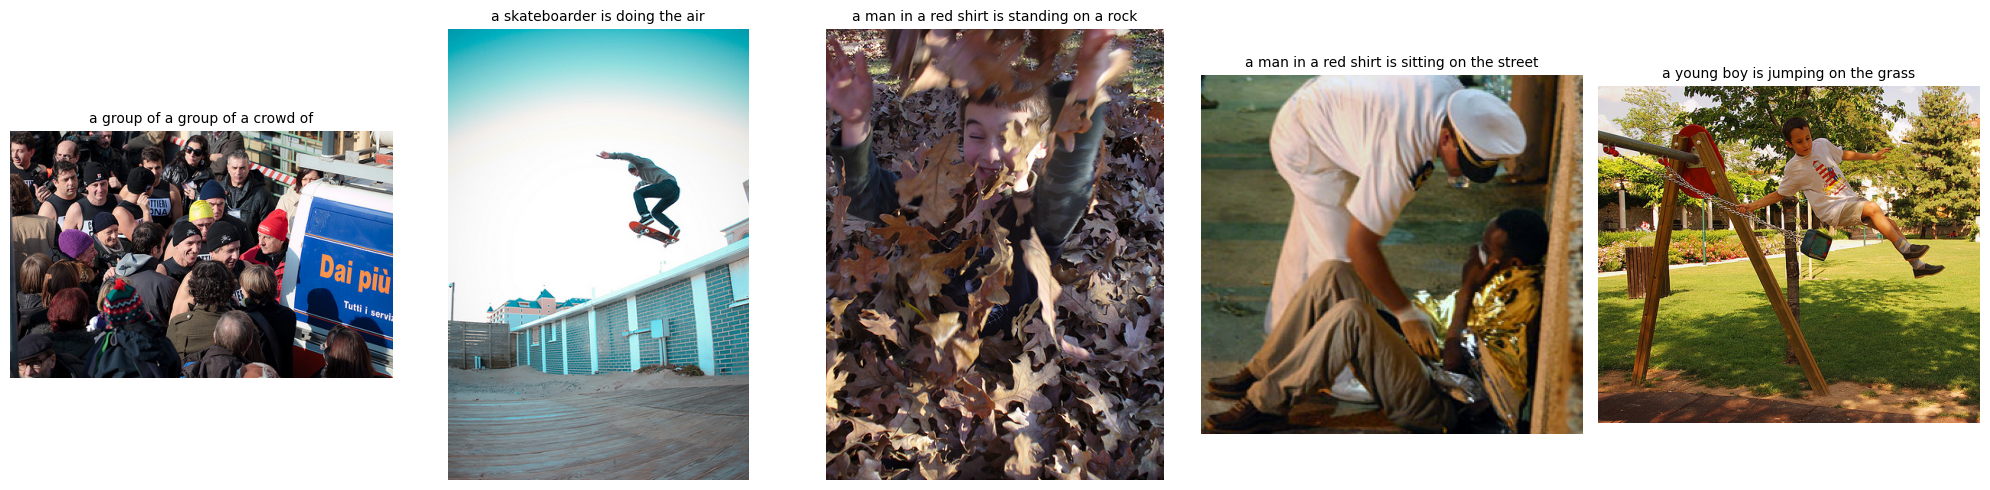

In [ ]:
# %% [code]
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Beam Search Caption Generation Function
def generate_caption_beam(feature, model, word2idx, idx2word, max_length, beam_width=3):
    """
    Generates caption for an image feature using beam search.

    Args:
      feature: Image feature vector of shape (7, 7, 512).
      model: Trained captioning model.
      word2idx: Dictionary mapping words to indices.
      idx2word: Dictionary mapping indices to words.
      max_length: Maximum caption sequence length.
      beam_width: Number of beams to keep at each step.

    Returns:
      Generated caption as a string.
    """
    # Each beam is a tuple (caption_sequence, score)
    beams = [([word2idx['<start>']], 0.0)]

    for i in range(max_length):
        new_beams = []
        # Expand each beam
        for seq, score in beams:
            sequence = pad_sequences([seq], maxlen=max_length, padding='post')
            preds = model.predict([np.expand_dims(feature, axis=0), sequence], verbose=0)
            # Use the prediction for the current time step
            probs = preds[0, i, :]
            # Get top beam_width predictions
            top_indices = np.argsort(probs)[-beam_width:]
            for idx in top_indices:
                if idx not in idx2word:
                    continue  # Skip unknown indices
                new_seq = seq + [int(idx)]
                new_score = score - np.log(probs[idx] + 1e-10)  # negative log likelihood
                new_beams.append((new_seq, new_score))
        # Keep best beam_width beams
        beams = sorted(new_beams, key=lambda x: x[1])[:beam_width]
        # If any beam ends with <end>, we can stop early (optional)
        if any(idx2word[beam[0][-1]] == '<end>' for beam in beams):
            break

    # Choose the best beam (with lowest score) and convert to words, filtering special tokens.
    best_seq = beams[0][0]
    caption_words = [idx2word[idx] for idx in best_seq if idx in idx2word and idx2word[idx] not in ['<start>', '<end>']]
    return ' '.join(caption_words)

# Select 5 random test images from the test set (test_df was created in Part 1)
unique_test_images = test_df['image'].unique()
sample_test_images = random.sample(list(unique_test_images), 5)
# Create a figure to display the test images and generated captions
plt.figure(figsize=(20, 5))

for i, img_file in enumerate(sample_test_images):
    # Get the image feature from the precomputed features dictionary (from Part 2)
    if img_file not in features_dict:
        continue
    feature = features_dict[img_file]

    # Generate caption using Beam Search
    caption = generate_caption_beam(feature, model, word2idx, idx2word, max_length, beam_width=3)

    # Load the image using matplotlib's imread (without preprocessing) for display
    img_path = os.path.join(images_dir, img_file)
    img = plt.imread(img_path)

    # Plot image and display generated caption as title
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(caption, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


Total test images: 10


Evaluating Test Images: 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


Average BLEU-4 score: 0.07382931168756944
Average METEOR score: 0.16019566693209225


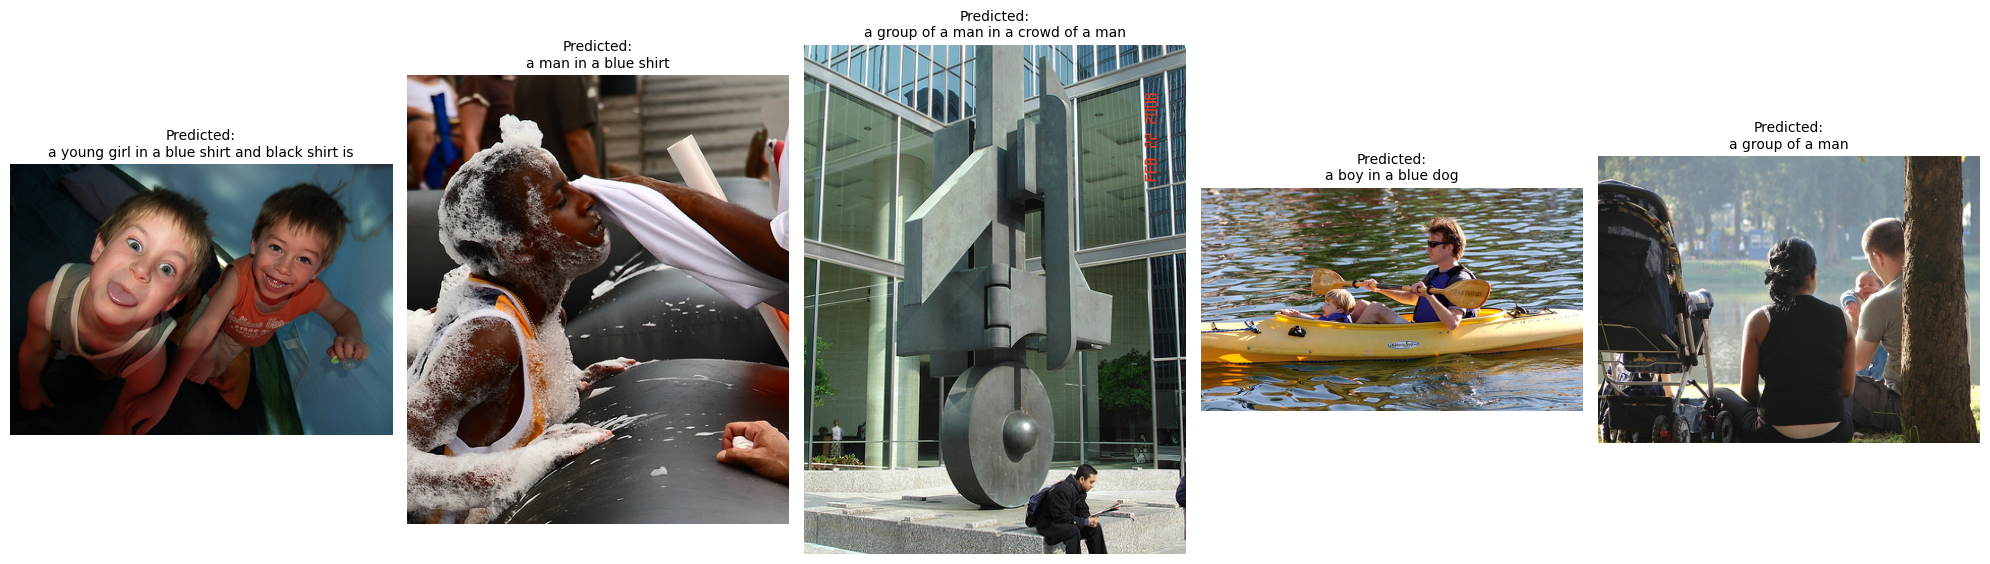

In [ ]:
# %% [code]
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

# Uncomment these lines if you haven't downloaded required NLTK data packages
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Initialize smoothing function for BLEU score calculation
smooth = SmoothingFunction().method4

# Get the unique test image IDs from the test dataframe (created in Part 1)
test_image_ids = test_df['image'].unique()[:10]
print("Total test images:", len(test_image_ids))

# Lists to accumulate scores for each image
bleu_scores = []
meteor_scores = []

# Dictionaries to store predictions and references for later qualitative analysis
predictions = {}
references = {}

# Evaluate on each test image with a progress bar
for img_id in tqdm(test_image_ids, desc="Evaluating Test Images"):
    # Ensure the image features are available (from Part 2)
    if img_id not in features_dict:
        continue

    # Get all ground truth captions for the current image
    gt_captions = test_df[test_df['image'] == img_id]['final_caption'].tolist()
    # Tokenize ground truth captions (each is a list of tokens)
    tokenized_refs = [caption.lower().split() for caption in gt_captions]

    # Generate caption using Beam Search (from Part 5)
    pred_caption = generate_caption_beam(features_dict[img_id], model, word2idx, idx2word, max_length, beam_width=3)
    tokenized_pred = pred_caption.lower().split()

    # Compute BLEU-4 score for the image caption
    bleu = sentence_bleu(tokenized_refs, tokenized_pred, smoothing_function=smooth)
    bleu_scores.append(bleu)

    # Compute METEOR score for the image caption (both hypothesis and references must be tokenized)
    meteor = meteor_score([ref.split() for ref in gt_captions], tokenized_pred)
    meteor_scores.append(meteor)

    # Save prediction and reference for qualitative analysis
    predictions[img_id] = pred_caption
    references[img_id] = gt_captions

# Compute average scores across test images
avg_bleu = sum(bleu_scores) / len(bleu_scores)
avg_meteor = sum(meteor_scores) / len(meteor_scores)
print("Average BLEU-4 score:", avg_bleu)
print("Average METEOR score:", avg_meteor)

# -----------------------------
# b. Qualitative Analysis: Visual Inspection
# Display 5 random test images with generated and ground-truth captions

sample_ids = random.sample(list(test_image_ids), 5)

plt.figure(figsize=(20, 10))
for i, img_id in enumerate(sample_ids):
    if img_id not in features_dict:
        continue
    # Load the image (without preprocessing) for display
    img_path = os.path.join(images_dir, img_id)
    img = plt.imread(img_path)

    # Retrieve the generated caption and all ground truth captions
    pred_caption = predictions.get(img_id, "No Prediction")
    gt_captions = references.get(img_id, [])

    # Plot the image
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title("Predicted:\n" + pred_caption, fontsize=10)
    plt.xlabel("Ground Truth:\n" + "\n".join(gt_captions), fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units)  # For image features
        self.W2 = tf.keras.layers.Dense(units)  # For hidden state
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features shape: (batch_size, 49, 512) -> assuming 7x7 spatial features
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)  # (batch_size, 1, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)  # (batch_size, 49, 1)

        context_vector = attention_weights * features  # (batch_size, 49, 512)
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch_size, 512)

        return context_vector, attention_weights


In [ ]:
class DecoderWithAttention(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super().__init__()
        self.units = units
        self.attention = BahdanauAttention(units)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(units, return_sequences=True, return_state=True)
        self.fc1 = tf.keras.layers.Dense(units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

    def call(self, x, features, hidden):
        # x: (batch_size, max_length)
        # features: (batch_size, 49, 512) from the CNN
        # hidden: (batch_size, units)

        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)  # (batch_size, max_length, embedding_dim)

        # Concatenate context vector to every timestep of input embeddings
        context_vector = tf.expand_dims(context_vector, 1)
        x = tf.concat([context_vector, x], axis=-1)

        output, state_h, state_c = self.lstm(x)
        x = self.fc1(output)
        x = self.fc2(x)

        return x, state_h, state_c, attention_weights


In [ ]:
embedding_dim = 256
units = 512
vocab_size = len(word2idx)

image_input = tf.keras.Input(shape=(7, 7, 512), name="image_input")
seq_input = tf.keras.Input(shape=(max_length,), name="caption_input")

features = tf.keras.layers.Reshape((49, 512))(image_input)
decoder = DecoderWithAttention(embedding_dim, units, vocab_size)

# Initial hidden state placeholder (handled dynamically in train_step)
initial_hidden = tf.keras.layers.Lambda(lambda x: tf.zeros((tf.shape(x)[0], units)))(seq_input)

output, _, _, _ = decoder(seq_input, features, initial_hidden)

model = tf.keras.Model(inputs=[image_input, seq_input], outputs=output)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(inputs, targets):
    img_tensor, dec_input = inputs
    with tf.GradientTape() as tape:
        hidden = tf.zeros((tf.shape(dec_input)[0], units))
        predictions, _, _, _ = decoder(dec_input, tf.reshape(img_tensor, (-1, 49, 512)), hidden)
        loss = loss_function(targets, predictions)

    gradients = tape.gradient(loss, decoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, decoder.trainable_variables))
    return loss, tf.reduce_sum(loss)

@tf.function
def test_step(inputs, targets):
    img_tensor, dec_input = inputs
    hidden = tf.zeros((tf.shape(dec_input)[0], units))
    predictions, _, _, _ = decoder(dec_input, tf.reshape(img_tensor, (-1, 49, 512)), hidden)
    loss = loss_function(targets, predictions)
    return loss, tf.reduce_sum(loss)

def loss_function(real, pred):
    mask = tf.math.not_equal(real, 0)
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)


In [ ]:
import time

loss_plot = []
test_loss_plot = []

start_epoch = 0
num_steps = steps_per_epoch

# TensorBoard
train_summary_writer = tf.summary.create_file_writer('logs/train')
test_summary_writer = tf.summary.create_file_writer('logs/test')

# Checkpoint manager
ckpt = tf.train.Checkpoint(optimizer=optimizer, decoder=decoder)
ckpt_manager = tf.train.CheckpointManager(ckpt, './checkpoints', max_to_keep=3)

for epoch in range(start_epoch, 20):
    start = time.time()
    total_loss_train = 0
    total_loss_test = 0

    # Training loop
    for (batch, ((img_tensor, cap_input), target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step((img_tensor, cap_input), target)
        total_loss_train += t_loss

    with train_summary_writer.as_default():
        tf.summary.scalar('LossTrain', (total_loss_train / num_steps), step=epoch)

    loss_plot.append(total_loss_train / num_steps)

    # Validation loop
    for (batch, ((img_tensor, cap_input), target)) in enumerate(val_dataset):
        batch_loss, t_loss = test_step((img_tensor, cap_input), target)
        total_loss_test += t_loss

    with test_summary_writer.as_default():
        tf.summary.scalar('LossTest', (total_loss_test / num_steps), step=epoch)

    test_loss_plot.append(total_loss_test / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print('Epoch {} TrainLoss {:.6f} TestLoss {:.6f}'.format(
        epoch + 1,
        total_loss_train / num_steps,
        total_loss_test / num_steps
    ))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 TrainLoss 1.607539 TestLoss 0.458554
Time taken for 1 epoch 126.77819323539734 sec

Epoch 2 TrainLoss 1.405468 TestLoss 0.499907
Time taken for 1 epoch 95.58435344696045 sec

Epoch 3 TrainLoss 1.307525 TestLoss 0.514737
Time taken for 1 epoch 94.84442591667175 sec

Epoch 4 TrainLoss 1.270033 TestLoss 0.512402
Time taken for 1 epoch 94.80027389526367 sec

Epoch 5 TrainLoss 1.241341 TestLoss 0.517693
Time taken for 1 epoch 95.04060125350952 sec

Epoch 6 TrainLoss 1.221944 TestLoss 0.525910
Time taken for 1 epoch 95.53870296478271 sec

Epoch 7 TrainLoss 1.214167 TestLoss 0.525249
Time taken for 1 epoch 94.70566248893738 sec

Epoch 8 TrainLoss 1.191599 TestLoss 0.522742
Time taken for 1 epoch 96.09206080436707 sec

Epoch 9 TrainLoss 1.178908 TestLoss 0.522654
Time taken for 1 epoch 93.7289764881134 sec

Epoch 10 TrainLoss 1.161890 TestLoss 0.531973
Time taken for 1 epoch 93.87629699707031 sec

Epoch 11 TrainLoss 1.148723 TestLoss 0.539658
Time taken for 1 epoch 93.85910439491272 se

No handles with labels found to put in legend.


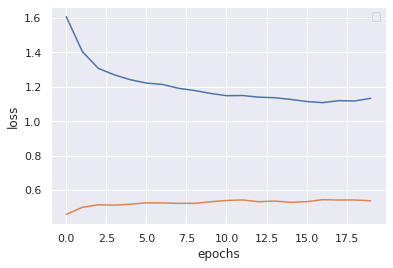

In [ ]:
for label in [loss_plot,test_loss_plot]:
    plt.plot(label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

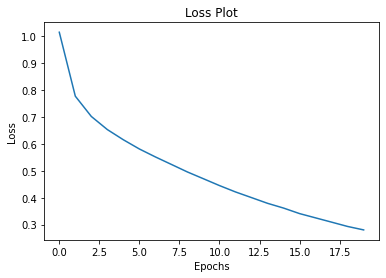

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
# Greedy Search
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = feature_extraction_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0) # Start token is <start> for LSTM
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id]) # Store the result or word predicted

        if tokenizer.index_word[predicted_id] == '<end>': # if you reach <end> token then return the result
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0) # Decoder input is the word predicted at previous timestep

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
# beam search
def evaluate(image, beam_index = 3):

    start = [tokenizer.word_index['<start>']]

    # result[0][0] = index of the starting word
    # result[0][1] = probability of the word predicted
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = feature_extraction_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:

          predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

          attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
          i=i+1
          # Getting the top <beam_index>(n) predictions
          word_preds = np.argsort(predictions[0])[-beam_index:]

          # creating a new list so as to put them via the model again
          for w in word_preds:
            next_cap, prob = s[0][:], s[1]
            next_cap.append(w)
            prob += predictions[0][w]
            temp.append([next_cap, prob])
        result = temp
        # Sorting according to the probabilities
        result = sorted(result, reverse=False, key=lambda l: l[1])
        # Getting the top words
        result = result[-beam_index:]

        predicted_id = result[-1] # with Max Probability
        pred_list = predicted_id[0]

        prd_id = pred_list[-1]
        if(prd_id!=3):
          dec_input = tf.expand_dims([prd_id], 0)  # Decoder input is the word predicted with highest probability among the top_k words predicted
        else:
          break

    result = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)

        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption,attention_plot



In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Flickr8k/Flicker8k_Dataset/2742426734_291df6da08.jpg
BELU score: 7.813586220751259
Real Caption: group of people posing for picture on the grass
Prediction Caption: man in the
time took to Predict: 0 sec


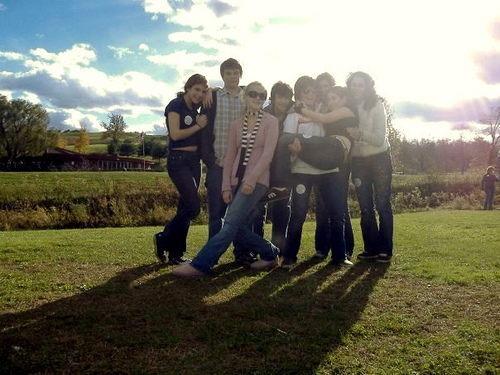

In [ ]:
# captions on the validation set

from PIL import Image

from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
print(image)
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)
# result is in this format:  ['woman', 'plays', 'volleyball', '<end>']
# We need to remove <end> and join the list elements into a sentence. Also we need to remove <unk> from real_captions


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result
result_join = ''.join(str(result))
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final.split()


score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

#plot_attention(image, result_final, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_test[rid])

Real Caption: <start> a close up of a banana on a bed <end>
Prediction Caption: a banana attached are next to a single [UNK] <end>


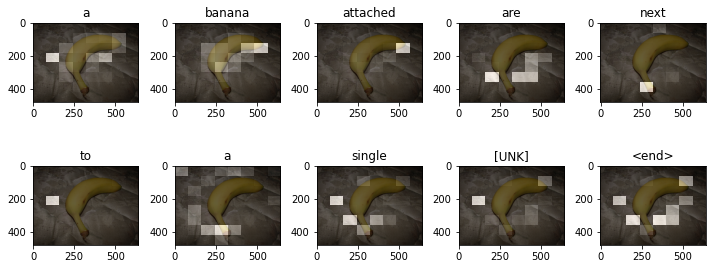

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [ ]:
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
print(real_caption)

<start> group of people posing for picture on the grass <end>


Flickr8k/Flicker8k_Dataset/3242007318_01e82171aa.jpg
BELU score: 0
Real Caption: two women standing in front of large brick building
Prediction Caption: t w o   m e n   i n   t h e   b a c k g r o u n
time took to Predict: 0 sec


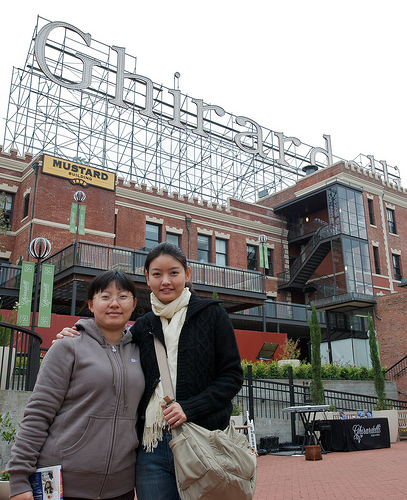

In [ ]:
# captions on the validation set

from PIL import Image

from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
print(image)
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

# plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_test[rid])

Flickr8k/Flicker8k_Dataset/413231421_43833a11f5.jpg
BELU score: 0
Real Caption: black dog is digging in the snow
Prediction Caption(Beam=3): t w o   d o g s   a r e   p l a y i n g   i n   t h e   s n o
time took to Predict: 0 sec


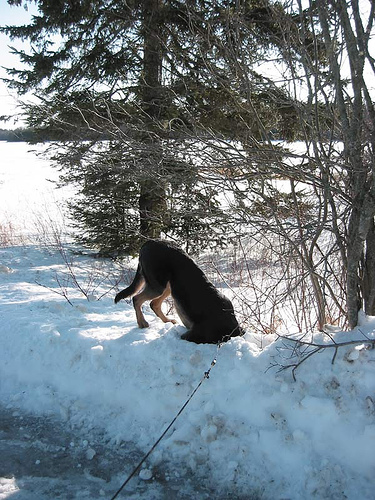

In [ ]:
# captions on the validation set

from PIL import Image

from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_test))
image = 'Flickr8k/Flicker8k_Dataset/413231421_43833a11f5.jpg'
print(image)
start = time.time()
real_caption = '<start> black dog is digging in the snow <end>'
result, attention_plot = evaluate(image)
# result is in this format:  ['woman', 'plays', 'volleyball', '<end>']
# We need to remove <end> and join the list elements into a sentence. Also we need to remove <unk> from real_captions


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption(Beam=3):', result_final)

# plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open('Flickr8k/Flicker8k_Dataset/413231421_43833a11f5.jpg')

In [ ]:
score = sentence_bleu('black dog is digging in the snow', 'dog is digging in the snow', weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")


BELU score: 65.04436355879909


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import numpy as np

nltk.download('wordnet')
nltk.download('omw-1.4')

def evaluate_bleu_meteor(predictions, references):
    """
    predictions: List of predicted captions (strings)
    references: List of reference captions (list of strings or list of list of strings)
    """

    assert len(predictions) == len(references), "Predictions and references must have the same length."

    bleu_scores = []
    meteor_scores = []
    smoothie = SmoothingFunction().method4

    for pred, ref in zip(predictions, references):
        # Tokenize
        pred_tokens = pred.split()
        ref_tokens = [r.split() for r in ref]

        # BLEU
        bleu = sentence_bleu(ref_tokens, pred_tokens, smoothing_function=smoothie)
        bleu_scores.append(bleu)

        # METEOR
        meteor = meteor_score(ref_tokens, pred_tokens)
        meteor_scores.append(meteor)

    avg_bleu = np.mean(bleu_scores)
    avg_meteor = np.mean(meteor_scores)

    print(f"Average BLEU Score: {avg_bleu:.4f}")
    print(f"Average METEOR Score: {avg_meteor:.4f}")

    return {
        "bleu": avg_bleu,
        "meteor": avg_meteor
    }


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
evaluate_bleu_meteor(preds, refs)

Average BLEU Score: 0.1305
Average METEOR Score: 0.7504


{'bleu': np.float64(0.13049474558796317),
 'meteor': np.float64(0.7503639303673457)}